# Generating the statistics for comparing deposited, AFITT-CIF and Phenix-AFITT ligand coordinates

This notebook will generate tables comparing

    Difference in 
        Energy as determined using MMFF94s
        R-free
        Bond lengths
        Bond angles
        
    for ligand coordinates taken from
        Deposited structures (Deposited)
        Deposited coordinates re-refined using an AFITT generated CIF (AFITT-CIF)
        Deposited coordinated re-refined using Phenix-AFITT (Phenix-AFITT)
            Used MMFF94s

Statistical significance was determined using

    dependent paired t-test -> stats.ttest_rel
    2 sample 1-sided Z test ->
    two sample distribution Kolmogorov-Smirnov test -> stats.ks_2sampl
    Wilcoxon (Wilcoxon results not reported) -> stats.wilcoxon

Substantive significance was determined using

    Cohen d - CohensEffectSize


In [71]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import re
import pickle
import pandas as pd
from scipy import stats
import math

In [72]:
# For Future Compatibility
from __future__ import division

from __future__ import print_function

In [73]:
%matplotlib inline

In [74]:
# Effect size estmation using Cohen's d. Larger d = more substantial effect/difference between two methods.
# THIS IS NOT IN ANY WAY RELATED TO STATISTICAL SIGNIFICANCE.
# d <= 0.2 - trivial effect  (there is no difference worth worrying about)
# 0.2 <= d < 0.5 - small effect.
# 0.5 <= d <= 0.8 - medium effect.
# d > 0.8 - large effect.
def CohensEffectSize(lis1,lis2):
    n1=len(lis1)
    n2=len(lis2)
    mean1=sp.mean(lis1)
    mean2=sp.mean(lis2)
    stddev1=sp.std(lis1)
    stddev2=sp.std(lis2)
    s1=math.sqrt((stddev1**2 + stddev2**2)/2)
    s2=math.sqrt((n1-1)*stddev1**2 + (n2-1)*stddev2**2)
#    d1=round(math.fabs(mean1-mean2)/s1,3)
    d2=round(math.fabs(mean1-mean2)*math.sqrt(n1+n2-2)/s2,3)

    return d2

In [75]:
# See the previous function for definitions
# This function takes mean and std dev instead of lists
# 
def CohensEffectSize2s(mean1,mean2,stddev1,stddev2,n1,n2):
    s1=math.sqrt((stddev1**2 + stddev2**2)/2)
    s2=math.sqrt((n1-1)*stddev1**2 + (n2-1)*stddev2**2)
    d2=round(math.fabs(mean1-mean2)*math.sqrt(n1+n2-2)/s2,3)

    return d2


In [76]:
# Calculate p values for Z scores
# Z score assumes a normal distribution i.e. sample size n>50
# Input is sample mean, standard deviation and sample size
# Ho neq Ha where mean1 corresponds to Ha

def Zscore_p_value(mean1,mean2,stddev1,stddev2,n1,n2):
    Z_value = (mean1 - mean2)/(math.sqrt((stddev1/n1) + (stddev2/n2)))
    zp=stats.norm.sf(abs(Z_value))
    
    return zp

In [77]:
# You will need to change the directory path to load the pickle.dat file
# Load data
with open("/Users/warreng3/Desktop/pickle.dat", "rb") as f:
    data_from_pickle = pickle.load(f)


Key for data in pickle.dat

    Energy (kJ/mol)
        Phenix-AFITT - data_from_pickle[0]
        AFITT-CIF - data_from_pickle[1]
        Deposited - data_from_pickle[2]
        
    R-free
        Phenix-AFITT - data_from_pickle[8]
        AFITT-CIF - data_from_pickle[9]
        
    Time for refinement (s)
        Phenix-AFITT - data_from_pickle[17]
        AFITT-CIF - data_from_pickle[16]
        
    Mogul data
        Bond deviation histogram
            Phenix-AFITT - data_from_pickle[21]
            AFITT-CIF - data_from_pickle[20]
            Deposited - data_from_pickle[19]
        Angle deviation histogram
            Phenix-AFITT - data_from_pickle[24]
            AFITT-CIF - data_from_pickle[23]
            Deposited - data_from_pickle[22]
            
The other fields contain data not used for or reported by the publication, i.e. other refinement methods or strategies.

In [78]:
# The mean and std dev data for the Mogul (csd) deviation data
# is not in the pickle.dat database.  It is entered as dictionary
# files here
mogul_bond = {'Mean': pd.Series([0.036, 0.019, 0.018], index=['Deposited', 'AFITT-CIF' ,'Phenix-AFITT']),
               'Std Dev': pd.Series([0.017, 0.007, 0.016], index=['Deposited', 'AFITT-CIF' ,'Phenix-AFITT'])
              }
mogul_angle = {'Mean': pd.Series([3.11, 2.77, 2.09], index=['Deposited', 'AFITT-CIF' ,'Phenix-AFITT']),
               'Std Dev': pd.Series([1.25, 0.84, 0.72], index=['Deposited', 'AFITT-CIF' ,'Phenix-AFITT'])
              }

In [79]:
# Calculate values for Energy (kJ/mol)
# dep = Deposited
# AC = AFITT-CIF
# PA = Phenix-AFITT

# Mean and Std Dev
E_dep_mean = sp.mean(data_from_pickle[2])
E_dep_std_dev = sp.std(data_from_pickle[2])
E_AC_mean = sp.mean(data_from_pickle[1])
E_AC_std_dev = sp.std(data_from_pickle[1])
E_PA_mean = sp.mean(data_from_pickle[0])
E_PA_std_dev = sp.std(data_from_pickle[0])

# Dependent 2 sample t-test
E_t_dep_vs_AC = stats.ttest_rel(data_from_pickle[2],data_from_pickle[1])
E_t_dep_vs_PA = stats.ttest_rel(data_from_pickle[2],data_from_pickle[0])
E_t_AC_vs_PA = stats.ttest_rel(data_from_pickle[1],data_from_pickle[0])

# 2 sample KS
E_ks_dep_vs_AC = stats.ks_2samp(data_from_pickle[2],data_from_pickle[1])
E_ks_dep_vs_PA = stats.ks_2samp(data_from_pickle[2],data_from_pickle[0])
E_ks_AC_vs_PA = stats.ks_2samp(data_from_pickle[1],data_from_pickle[0])

# Wilcoxon
E_W_dep_vs_AC = stats.wilcoxon(data_from_pickle[2],data_from_pickle[1])
E_W_dep_vs_PA = stats.wilcoxon(data_from_pickle[2],data_from_pickle[0])
E_W_AC_vs_PA = stats.wilcoxon(data_from_pickle[1],data_from_pickle[0])

# Cohen d
E_d_dep_vs_AC = CohensEffectSize(data_from_pickle[2],data_from_pickle[1])
E_d_dep_vs_PA = CohensEffectSize(data_from_pickle[2],data_from_pickle[0])
E_d_AC_vs_PA = CohensEffectSize(data_from_pickle[1],data_from_pickle[0])


In [80]:
# Dictionary file for the Energy statistics
energy = {'Mean': pd.Series(['{:.3G}'.format(float(E_dep_mean)), '{:.3G}'.format(float(E_AC_mean)), '{:.3G}'.format(float(E_PA_mean))], 
                        index=['Deposited', 'AFITT-CIF' ,'Phenix-AFITT']),
     'Std Dev' : pd.Series(['{:.3G}'.format(float(E_dep_std_dev)), '{:.3G}'.format(float(E_AC_std_dev)), '{:.3G}'.format(float(E_PA_std_dev))], 
                        index=['Deposited', 'AFITT-CIF' ,'Phenix-AFITT']),
     'dep t-test': pd.Series(['{:.3G}'.format(float(E_t_dep_vs_AC[0])), '{:.3G}'.format(float(E_t_dep_vs_PA[0])), '{:.3G}'.format(float(E_t_AC_vs_PA[0]))],
                             index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'dep t-test (p)': pd.Series(['{:.3G}'.format(float(E_t_dep_vs_AC[1])), '{:.3G}'.format(float(E_t_dep_vs_PA[1])), '{:.3G}'.format(float(E_t_AC_vs_PA[1]))],
                             index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'ks 2-sample': pd.Series(['{:.3G}'.format(float(E_ks_dep_vs_AC[0])), '{:.3G}'.format(float(E_ks_dep_vs_PA[0])), '{:.3G}'.format(float(E_ks_AC_vs_PA[0]))],
                             index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'ks 2-sample (p)': pd.Series(['{:.3G}'.format(float(E_ks_dep_vs_AC[1])), '{:.3G}'.format(float(E_ks_dep_vs_PA[1])), '{:.3G}'.format(float(E_ks_AC_vs_PA[1]))],
                             index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'Wilcoxon': pd.Series(['{:.3G}'.format(float(E_W_dep_vs_AC[0])), '{:.3G}'.format(float(E_W_dep_vs_PA[0])), '{:.3G}'.format(float(E_W_AC_vs_PA[0]))],
                             index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'Wilcoxon (p)': pd.Series(['{:.3G}'.format(float(E_W_dep_vs_AC[1])), '{:.3G}'.format(float(E_W_dep_vs_PA[1])), '{:.3G}'.format(float(E_W_AC_vs_PA[1]))],
                             index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'Cohen d': pd.Series(['{:.3G}'.format(float(E_d_dep_vs_AC)), '{:.3G}'.format(float(E_d_dep_vs_PA)), '{:.3G}'.format(float(E_d_AC_vs_PA))],
                             index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT'])
         }

In [81]:
# Calculate values for R factor
# dep = Deposited
# AC = AFITT-CIF
# PA = Phenix-AFITT
# Mean and Std Dev
# Because not all deposited structures had 
# reported R free values none were included

R_AC_mean = sp.mean(data_from_pickle[9])
R_AC_std_dev = sp.std(data_from_pickle[9])
R_PA_mean = sp.mean(data_from_pickle[8])
R_PA_std_dev = sp.std(data_from_pickle[8])

# Dependent 2 sample t-test
R_t_AC_vs_PA = stats.ttest_rel(data_from_pickle[9],data_from_pickle[8])

# 2 sample KS
R_ks_AC_vs_PA = stats.ks_2samp(data_from_pickle[9],data_from_pickle[8])

# Wilcoxon
R_W_AC_vs_PA = stats.wilcoxon(data_from_pickle[9],data_from_pickle[8])

# Cohen d
R_d_AC_vs_PA = CohensEffectSize(data_from_pickle[9],data_from_pickle[8])


In [82]:
# Load Mogul bond and angle difference data
# dep = Deposited
# AC = AFITT-CIF
# PA = Phenix-AFITT

bond_dep=data_from_pickle[19]
bond_AC=data_from_pickle[20]
bond_PA=data_from_pickle[21]
ang_dep=data_from_pickle[22]
ang_AC=data_from_pickle[23]
ang_PA=data_from_pickle[24]

# Get sample size for
# bonds (bdep) and angles (adep)

n_bdep=np.sum(bond_dep[:,1])
n_bAC=np.sum(bond_AC[:,1])
n_bPA=np.sum(bond_PA[:,1])
n_adep=np.sum(ang_dep[:,1])
n_aAC=np.sum(ang_AC[:,1])
n_aPA=np.sum(ang_PA[:,1])


In [83]:
# Dictionary file for R free statistics
Rfree = {'Mean': pd.Series(['{:.3G}'.format(float(R_AC_mean)), '{:.3G}'.format(float(R_PA_mean))], 
                        index=['AFITT-CIF' ,'Phenix-AFITT']),
     'Std Dev' : pd.Series(['{:.3G}'.format(float(R_AC_std_dev)), '{:.3G}'.format(float(R_PA_std_dev))], 
                        index=['AFITT-CIF' ,'Phenix-AFITT']),
     'dep t-test': pd.Series(['', '', '{:.3G}'.format(float(R_t_AC_vs_PA[0]))],
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'dep t-test (p)': pd.Series(['', '', '{:.3G}'.format(float(R_t_AC_vs_PA[1]))],
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'ks 2-sample': pd.Series(['', '', '{:.3G}'.format(float(R_ks_AC_vs_PA[0]))],
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'ks 2-sample (p)': pd.Series(['', '', '{:.3G}'.format(float(R_ks_AC_vs_PA[1]))],
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'Wilcoxon': pd.Series(['', '', '{:.3G}'.format(float(R_W_AC_vs_PA[0]))],
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'Wilcoxon (p)': pd.Series(['', '', '{:.3G}'.format(float(R_W_AC_vs_PA[1]))],
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
     'Cohen d': pd.Series(['', '', '{:.3G}'.format(float(R_d_AC_vs_PA))],
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
         }

In [84]:
# Calculate statistics for Mogul bond results
# Z score p value - Zp
Zp_bond_dep_vs_AC = Zscore_p_value(mogul_bond['Mean']['AFITT-CIF'],mogul_bond['Mean']['Deposited'],mogul_bond['Std Dev']['AFITT-CIF'],mogul_bond['Std Dev']['Deposited'],n_bAC,n_bdep)
Zp_bond_dep_vs_PA = Zscore_p_value(mogul_bond['Mean']['Phenix-AFITT'],mogul_bond['Mean']['Deposited'],mogul_bond['Std Dev']['Phenix-AFITT'],mogul_bond['Std Dev']['Deposited'],n_bPA,n_bdep)
Zp_bond_AC_vs_PA = Zscore_p_value(mogul_bond['Mean']['AFITT-CIF'],mogul_bond['Mean']['Phenix-AFITT'],mogul_bond['Std Dev']['AFITT-CIF'],mogul_bond['Std Dev']['Phenix-AFITT'],n_bAC,n_bPA)

# Cohen d - d
d_bond_dep_vs_AC = CohensEffectSize2s(mogul_bond['Mean']['AFITT-CIF'],mogul_bond['Mean']['Deposited'],mogul_bond['Std Dev']['AFITT-CIF'],mogul_bond['Std Dev']['Deposited'],n_bAC,n_bdep)
d_bond_dep_vs_PA = CohensEffectSize2s(mogul_bond['Mean']['Phenix-AFITT'],mogul_bond['Mean']['Deposited'],mogul_bond['Std Dev']['Phenix-AFITT'],mogul_bond['Std Dev']['Deposited'],n_bPA,n_bdep)
d_bond_AC_vs_PA = CohensEffectSize2s(mogul_bond['Mean']['Phenix-AFITT'],mogul_bond['Mean']['AFITT-CIF'],mogul_bond['Std Dev']['Phenix-AFITT'],mogul_bond['Std Dev']['AFITT-CIF'],n_bPA,n_bAC)

In [85]:
# Dictionary file for Mogul bond difference statistics
# For the 2 sample tests - 2 sample Z-test and Cohen D
# Deposited = Dep vs Phenix-AFITT
# AFITT-CIF = Dep vs AFITT-CIF
# Phenix-AFITT = AFITT-CIF vs Phenix-AFITT

Bond = {'Mean': pd.Series(['{:.3G}'.format(float(mogul_bond['Mean']['Deposited'])), '{:.3G}'.format(float(mogul_bond['Mean']['AFITT-CIF'])), '{:.3G}'.format(float(mogul_bond['Mean']['Phenix-AFITT']))], 
                        index=['Deposited','AFITT-CIF' ,'Phenix-AFITT']),
              'Std Dev': pd.Series(['{:.3G}'.format(float(mogul_bond['Std Dev']['Deposited'])), '{:.3G}'.format(float(mogul_bond['Std Dev']['AFITT-CIF'])), '{:.3G}'.format(float(mogul_bond['Std Dev']['Phenix-AFITT']))], 
                        index=['Deposited','AFITT-CIF' ,'Phenix-AFITT']),
              '2 sample Z-test (p)': pd.Series(['{:.3G}'.format(float(Zp_bond_dep_vs_AC)), '{:.3G}'.format(float(Zp_bond_dep_vs_PA)), '{:.3G}'.format(float(Zp_bond_AC_vs_PA))], 
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
              'Cohen d': pd.Series(['{:.3G}'.format(float(d_bond_dep_vs_AC)), '{:.3G}'.format(float(d_bond_dep_vs_PA)), '{:.3G}'.format(float(d_bond_AC_vs_PA))], 
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
             }


In [86]:
# Calculate statistics for Mogul angle results
# Z score p value - Zp
Zp_angle_dep_vs_AC = Zscore_p_value(mogul_angle['Mean']['AFITT-CIF'],mogul_angle['Mean']['Deposited'],mogul_angle['Std Dev']['AFITT-CIF'],mogul_angle['Std Dev']['Deposited'],n_aAC,n_adep)
Zp_angle_dep_vs_PA = Zscore_p_value(mogul_angle['Mean']['Phenix-AFITT'],mogul_angle['Mean']['Deposited'],mogul_angle['Std Dev']['Phenix-AFITT'],mogul_angle['Std Dev']['Deposited'],n_aPA,n_adep)
Zp_angle_AC_vs_PA = Zscore_p_value(mogul_angle['Mean']['AFITT-CIF'],mogul_angle['Mean']['Phenix-AFITT'],mogul_angle['Std Dev']['AFITT-CIF'],mogul_angle['Std Dev']['Phenix-AFITT'],n_aAC,n_aPA)

# Cohen d - d
d_angle_dep_vs_AC = CohensEffectSize2s(mogul_angle['Mean']['AFITT-CIF'],mogul_angle['Mean']['Deposited'],mogul_angle['Std Dev']['AFITT-CIF'],mogul_angle['Std Dev']['Deposited'],n_aAC,n_adep)
d_angle_dep_vs_PA = CohensEffectSize2s(mogul_angle['Mean']['Phenix-AFITT'],mogul_angle['Mean']['Deposited'],mogul_angle['Std Dev']['Phenix-AFITT'],mogul_angle['Std Dev']['Deposited'],n_aPA,n_adep)
d_angle_AC_vs_PA = CohensEffectSize2s(mogul_angle['Mean']['Phenix-AFITT'],mogul_angle['Mean']['AFITT-CIF'],mogul_angle['Std Dev']['Phenix-AFITT'],mogul_angle['Std Dev']['AFITT-CIF'],n_aPA,n_aAC)

In [89]:
# Dictionary file for Mogul angle difference statistics
# For the 2 sample tests - 2 sample Z-test and Cohen D
# Deposited = Dep vs Phenix-AFITT
# AFITT-CIF = Dep vs AFITT-CIF
# Phenix-AFITT = AFITT-CIF vs Phenix-AFITT

Angle = {'Mean': pd.Series(['{:.3G}'.format(float(mogul_angle['Mean']['Deposited'])), '{:.3G}'.format(float(mogul_angle['Mean']['AFITT-CIF'])), '{:.3G}'.format(float(mogul_angle['Mean']['Phenix-AFITT']))], 
                        index=['Deposited','AFITT-CIF' ,'Phenix-AFITT']),
              'Std Dev': pd.Series(['{:.3G}'.format(float(mogul_angle['Std Dev']['Deposited'])), '{:.3G}'.format(float(mogul_angle['Std Dev']['AFITT-CIF'])), '{:.3G}'.format(float(mogul_angle['Std Dev']['Phenix-AFITT']))], 
                        index=['Deposited','AFITT-CIF' ,'Phenix-AFITT']),
              '2 sample Z-test (p)': pd.Series(['{:.3G}'.format(float(Zp_angle_dep_vs_AC)), '{:.3G}'.format(float(Zp_angle_dep_vs_PA)), '{:.3G}'.format(float(Zp_angle_AC_vs_PA))], 
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
              'Cohen d': pd.Series(['{:.3G}'.format(float(d_angle_dep_vs_AC)), '{:.3G}'.format(float(d_angle_dep_vs_PA)), '{:.3G}'.format(float(d_angle_AC_vs_PA))], 
                        index=['Dep v AFITT-CIF', 'Dep v Phenix-AFITT', 'AFITT-CIF v Phenix-AFITT']),
             }


In [92]:
# print energy statistics table
df_energy = pd.DataFrame(energy, columns=['Mean', 'Std Dev'])
df_energy.columns.name = 'Energy'
df_energy

Energy       Mean Std Dev
Deposited     402     210
AFITT-CIF     351     200
Phenix-AFITT  261     128

In [93]:
# print energy statistics table
# the statistical test is (Ho | Ha=Hb)
df_energy_stats = pd.DataFrame(energy, columns=['dep t-test (p)', 'ks 2-sample (p)', 'Wilcoxon (p)', 'Cohen d'])
df_energy_stats.columns.name = 'Energy'
df_energy_stats

Energy                   dep t-test (p) ks 2-sample (p) Wilcoxon (p) Cohen d
Dep v AFITT-CIF                5.21E-10        7.74E-05     9.34E-17    0.25
Dep v Phenix-AFITT             7.11E-58        7.69E-26     1.35E-51   0.813
AFITT-CIF v Phenix-AFITT          2E-33        2.67E-09     1.35E-51   0.537

In [94]:
# print R-factor statistics table
df_Rfree = pd.DataFrame(Rfree, columns=['Mean', 'Std Dev'])
df_Rfree.columns.name = 'Rfree'
df_Rfree

Rfree          Mean Std Dev
AFITT-CIF     0.231  0.0352
Phenix-AFITT  0.232  0.0363

In [95]:
# print energy statistics table
# the statistical test is (Ho | Ha=Hb)
df_Rfree_stats = pd.DataFrame(Rfree, columns=['dep t-test (p)', 'ks 2-sample (p)', 'Wilcoxon (p)', 'Cohen d'])
df_Rfree_stats.columns.name = 'Rfree'
df_Rfree_stats

Rfree                    dep t-test (p) ks 2-sample (p) Wilcoxon (p) Cohen d
Dep v AFITT-CIF                                                             
Dep v Phenix-AFITT                                                          
AFITT-CIF v Phenix-AFITT       1.75E-09           0.995     4.54E-12   0.033

In [96]:
# print Mogul bond difference statistics table
df_Bond = pd.DataFrame(Bond, columns=['Mean', 'Std Dev'])
df_Bond.columns.name = 'Bond Differences'
df_Bond

Bond Differences   Mean Std Dev
Deposited         0.036   0.017
AFITT-CIF         0.019   0.007
Phenix-AFITT      0.018   0.016

In [97]:
# print Mogul bond difference statistics table
# the statistical test is (Ho | Ha=Hb)
df_Bond_stats = pd.DataFrame(Bond, columns=['2 sample Z-test (p)', 'Cohen d'])
df_Bond_stats.columns.name = 'Bond Differences'
df_Bond_stats

Bond Differences         2 sample Z-test (p) Cohen d
Dep v AFITT-CIF                     0.000863    1.63
Dep v Phenix-AFITT                   0.00119    1.11
AFITT-CIF v Phenix-AFITT                0.39   0.083

In [98]:
# print Mogul angle difference statistics table
df_Angle = pd.DataFrame(Angle, columns=['Mean', 'Std Dev'])
df_Angle.columns.name = 'Angle Differences'
df_Angle

Angle Differences  Mean Std Dev
Deposited          3.11    1.25
AFITT-CIF          2.77    0.84
Phenix-AFITT       2.09    0.72

In [99]:
# print Mogul angle difference statistics table
# the statistical test is (Ho | Ha=Hb)
df_Angle_stats = pd.DataFrame(Angle, columns=['2 sample Z-test (p)', 'Cohen d'])
df_Angle_stats.columns.name = 'Angle Differences'
df_Angle_stats

Angle Differences        2 sample Z-test (p) Cohen d
Dep v AFITT-CIF                     9.26E-13   0.355
Dep v Phenix-AFITT                  6.2E-100    1.14
AFITT-CIF v Phenix-AFITT            7.8E-122   0.865

In [100]:
# Generate a difference array Phenix-Afitt - AFITT-CIF R free
diflist_PA_AC = (np.array(data_from_pickle[9]) - np.array(data_from_pickle[8]))

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   6.,   5.,   4.,   8.,   9.,   6.,  12.,  16.,  30.,
         29.,  32.,  18.,   7.,   1.,   3.]),
 array([ -2.53000000e-02,  -2.47380000e-02,  -2.41760000e-02,
         -2.36140000e-02,  -2.30520000e-02,  -2.24900000e-02,
         -2.19280000e-02,  -2.13660000e-02,  -2.08040000e-02,
         -2.02420000e-02,  -1.96800000e-02,  -1.91180000e-02,
         -1.85560000e-02,  -1.79940000e-02,  -1.74320000e-02,
         -1.68700000e-02,  -1.63080000e-02,  -1.57460000e-02,
         -1.51840000e-02,  -1.46220000e-02,  -1.40600000e-02,
         -1.34980000e-02,  -1.29360000e-02,  -1.23740000e-02,
         -1.18120000e-02,  -1.12500000e-02,  -1.06880000e-02,
         -1.01260000e-02,  -9.56400000e-03,  -9.00200000e-03,
         -8.44000000e-03,  -7.87800000

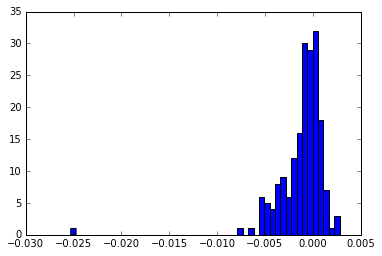

In [101]:
plt.hist(diflist_PA_AC,bins = 50)